# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomSolarize(threshold =.5, p=0.2),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Create training set and define training dataloader
train_data = torchvision.datasets.CIFAR10(root='./cifar/', train=True, download=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
# Create test set and define test dataloader
test_data = torchvision.datasets.CIFAR10(root='./cifar/', train=False, download=True, transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

Files already downloaded and verified
cat


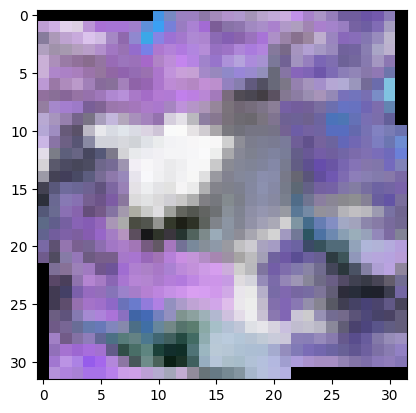

deer


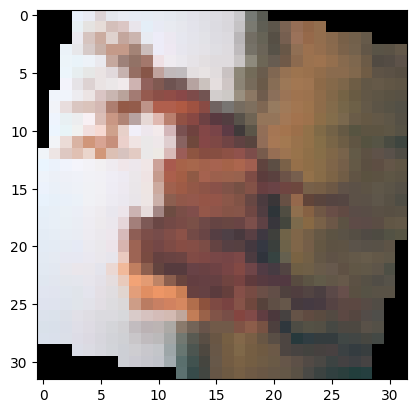

deer


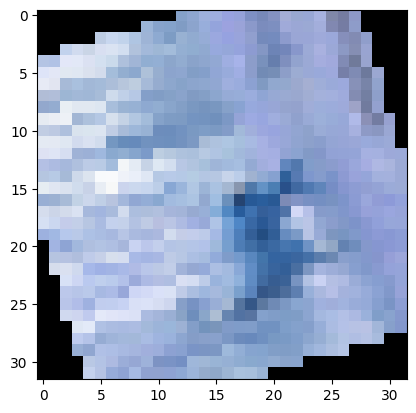

deer


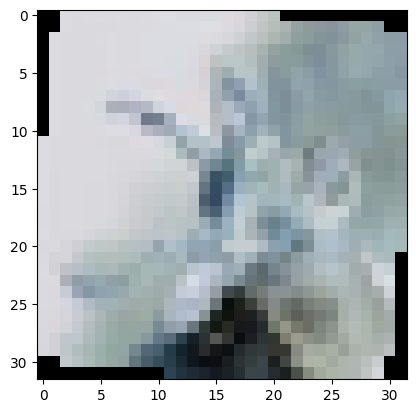

cat


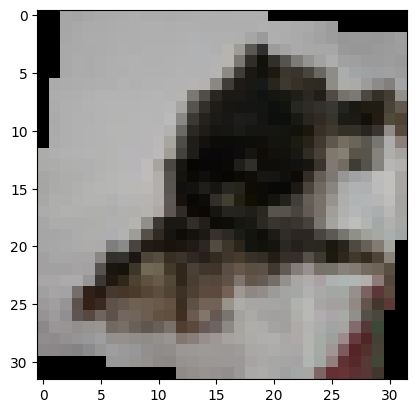

In [5]:
# Explore data
# Define transforms
vis_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomSolarize(threshold =.5, p=0.2),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
])
vis_data = torchvision.datasets.CIFAR10(root='./cifar/', train=False, download=True, transform=vis_transforms)
visloader = torch.utils.data.DataLoader(vis_data, batch_size=64, shuffle=True)
show5(visloader)

In [6]:
image, _ = next(iter(trainloader))
image.shape

torch.Size([64, 3, 32, 32])

Input channels = 3 (RGB channels) \
Output dim = 10 (10 classes)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [55]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.features = nn.Sequential(
                                # Out shape = (In_dim - Filter_Size + 2*Padding)/Stride + 1
                                nn.Conv2d(3, 20, 3),        # 3x32x32 -> 20x30x30
                                nn.ReLU(inplace=True),
                                nn.BatchNorm2d(20),
                                nn.Conv2d(20, 100, 3),      # 20x30x30 -> 100x28x28
                                nn.ReLU(inplace=True),
                                nn.BatchNorm2d(100),
                                nn.MaxPool2d(3),            # 20x30x30 -> 100x9x9
                                nn.Flatten(start_dim=1),    # 100x9x9 -> 8100
                                nn.Linear(8100, 1028),
                                nn.ReLU(inplace=True),
                                nn.Dropout(0.2),
                                nn.Linear(1028, 256),
                                nn.ReLU(inplace=True),
                                nn.Dropout(0.2),
                                nn.Linear(256, 128),
                                nn.ReLU(inplace=True),
                                nn.Dropout(0.2),
                                nn.Linear(128, 64),
                                nn.ReLU(inplace=True)
                            )
        
        self.classifier = nn.Sequential(
                                nn.Linear(64 ,10),
                                nn.LogSoftmax(dim=1)
                            )

    def forward(self, x):
        
        x = self.features(x)
        x = self.classifier(x)
        return x
model = Network()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [57]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [58]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')
train_loss = []
test_loss = []
epochs = 50
model.to(device)

for e in range(epochs):
    epoch_train_loss = 0
    epoch_test_loss = 0
    acc = []
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        p = model(images)
        loss = criterion(p, labels)
        p = torch.exp(p)
        _, top_class = p.topk(1, dim=1)
        batch_acc = top_class == labels.view(*top_class.shape)
        if len(acc) > 0:
            torch.concat((acc, batch_acc))
        else:
            acc = batch_acc
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    else:
        with torch.no_grad():
            model.eval()
            train_acc = torch.mean(acc.type(torch.FloatTensor))
            acc = []
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.to(device)

                p = model(images)
                loss = criterion(p, labels)
                epoch_test_loss += loss.item()
                p = torch.exp(p)
                _, top_class = p.topk(1, dim=1)
                batch_acc = top_class == labels.view(*top_class.shape)
                if len(acc) > 0:
                    torch.concat((acc, batch_acc))
                else:
                    acc = batch_acc
            acc = torch.mean(acc.type(torch.FloatTensor))
    
    model.train()
    train_loss.append(epoch_train_loss/len(trainloader))
    test_loss.append(epoch_test_loss/len(testloader))
    print(f"Epoch: {e};\tTrain Acc: {train_acc};\tTrain Loss: {train_loss[-1]}\tTest Acc: {acc}\tTest Loss: {test_loss[-1]}")

Using cuda:0
Epoch: 0;	Train Acc: 0.078125;	Train Loss: 1.7087149746582637	Test Acc: 0.515625	Test Loss: 1.277314863387187
Epoch: 1;	Train Acc: 0.46875;	Train Loss: 1.3905877222490433	Test Acc: 0.671875	Test Loss: 1.0984921994482635
Epoch: 2;	Train Acc: 0.6875;	Train Loss: 1.257941144430424	Test Acc: 0.59375	Test Loss: 1.0081088269592091
Epoch: 3;	Train Acc: 0.59375;	Train Loss: 1.1721345899659958	Test Acc: 0.609375	Test Loss: 0.9465865709219768
Epoch: 4;	Train Acc: 0.546875;	Train Loss: 1.1056976869435566	Test Acc: 0.71875	Test Loss: 0.8794550235104409
Epoch: 5;	Train Acc: 0.703125;	Train Loss: 1.0521287070515821	Test Acc: 0.75	Test Loss: 0.8574615496738701
Epoch: 6;	Train Acc: 0.640625;	Train Loss: 1.0265295009326447	Test Acc: 0.734375	Test Loss: 0.8175739942082934
Epoch: 7;	Train Acc: 0.59375;	Train Loss: 0.9969256607925191	Test Acc: 0.734375	Test Loss: 0.8181133501848598
Epoch: 8;	Train Acc: 0.75;	Train Loss: 0.9612057376700593	Test Acc: 0.828125	Test Loss: 0.817013781541472
Epoch:

Plot the training loss (and validation loss/accuracy, if recorded).

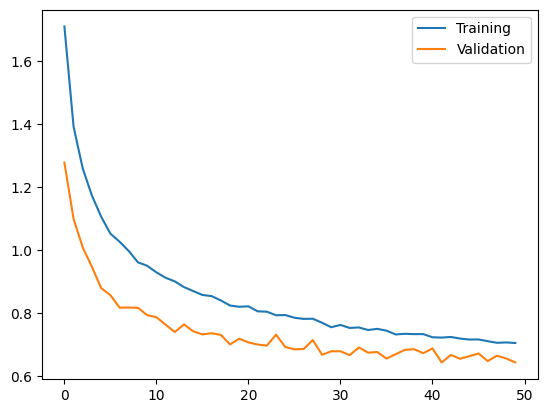

In [60]:
plt.plot(range(epochs), train_loss,  label='Training')
plt.plot(range(epochs), test_loss, label='Validation')
plt.legend()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [68]:
model.eval()
acc = []
for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)

    x = model(images)
    p = torch.exp(x)
    _, classes = p.topk(1, dim=1)
    equals = classes == labels.view(*classes.shape)
    if len(acc) < 1:
        acc = equals
    else:
        acc = torch.concat((acc, equals))

acc = torch.mean(acc.type(torch.float64))
print(f'Validation Accuracy: {acc:.2%}')

Validation Accuracy: 78.68%


## Saving your model
Using `torch.save`, save your model for future loading.

In [69]:
torch.save(model.state_dict(), 'image_classifier.pt')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Based on the evaluation above it would be advantageous to build an in-house image classifier rather than buying the model offered by "Detectocorp". The model created above beats the algorithm for sale by offering an accuracy of 78.68% which is higher than Detectocorp's 70%. The training cost is also minimal being that the in-house model above can be trained on a single GPU in about 30 minutes. Depending on the company’s budget, the savings from building an in-house model can be put towards additional resources to improve the model above. Further improvements could include:

- Additional augmentations to the training images and larger batch sizes to increase the training set size
- Additional convolutional layers to deepen the network and extract more features
- Increasing the number of training epochs to allow the model more time to fit the data
- The implementation of methods such as "Early Stopping" to further reduce overfitting

Furthermore, the company could even make use of open source models such as GPipe and finetune the pretrained weights to the company's use case.
